# Deskripsi tugas

Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Buat model untuk prediksi seperti itu.

Metrik RMSE pada *test set* tidak boleh lebih dari 48.

## Instruksi tugas

1. Unduh data dan lakukan *resampling* dalam satu jam.
2. Analisis datanya.
3.  Latih model yang berbeda dengan hiperparameter yang berbeda pula. Sampel tes harus 10% dari *dataset* awal.
4. Uji data menggunakan sampel tes dan berikan kesimpulan.

## Deskripsi data

Data tersimpan di file `taxi.csv`. Jumlah pesanan di kolom'*num_orders*'.

## Persiapan

### Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN
from xgboost import XGBRegressor

### Path dan Informasi Umum

In [ ]:
path = '/datasets/taxi.csv'

In [ ]:
data = pd.read_csv(path, index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
#Membuat Resample data 1 Jam
data = data.resample('1H').sum()

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
data['num_orders'] = data['num_orders'].astype('int64')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [ ]:
data.shape

(4416, 1)

In [ ]:
data.isna().sum()

num_orders    0
dtype: int64

In [ ]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<AxesSubplot:xlabel='num_orders'>

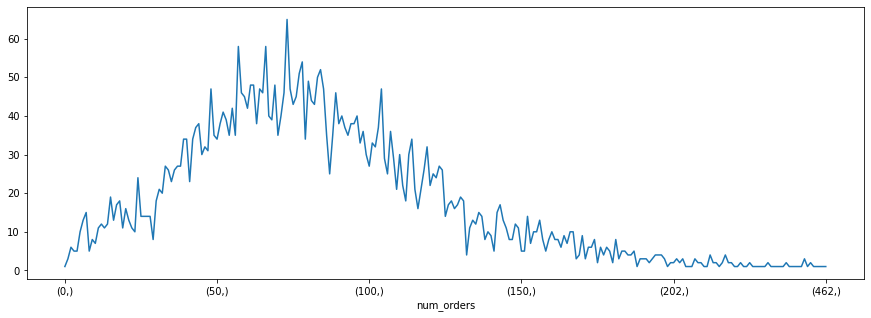

In [ ]:
data.value_counts().sort_index().plot(figsize=(15,5))

In [ ]:
decomposed = seasonal_decompose(data)

Text(0.5, 1.0, 'Residuals')

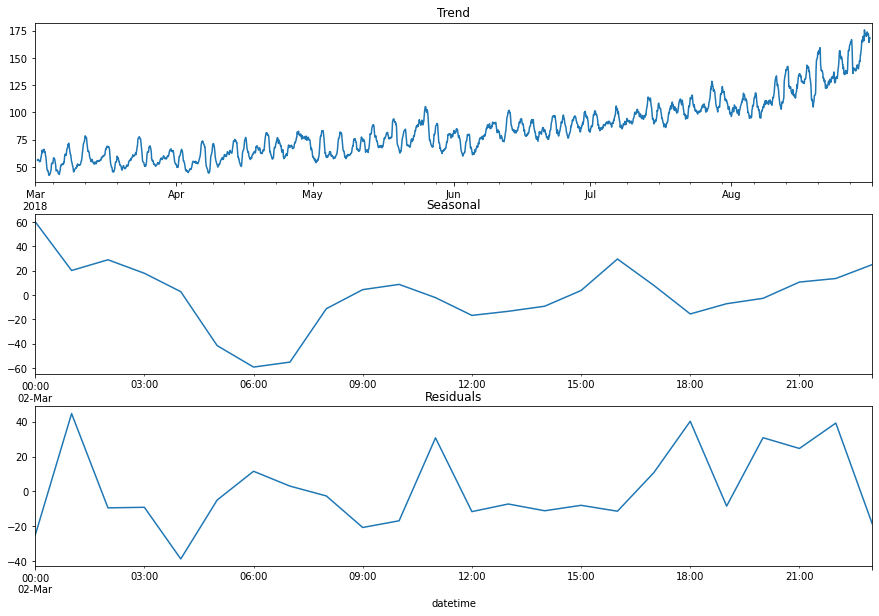

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(3,1,2)
decomposed.seasonal[24:48].plot(ax=plt.gca())
plt.title('Seasonal')
plt.subplot(3,1,3)
decomposed.resid[24:48].plot(ax=plt.gca())
plt.title('Residuals')

### Menambahkan Fitur

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean())
    return data

In [ ]:
data_1 = make_features(data,5,5)

In [ ]:
data_1.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN


### Kesimpulan

1. Pesanan Taksi di bandara memiliki Tren kenaikan dari bulan Maret 2018
2. Jam jam yang memiliki jumlah pesanan taksi meningkat di jam berangkat kerja (06-10) dan jam malam (18-24)

## Analisis

### Split Data

In [ ]:
train, test = train_test_split(data_1, shuffle=False, test_size=0.1)
train = train.dropna()

In [ ]:
features_train = train.drop(columns = 'num_orders',axis = 1)
target_train = train['num_orders']
features_test = test.drop(columns = 'num_orders',axis = 1)
target_test = test['num_orders']


### Fungsi MAE

In [ ]:
def hasil_mae(model):
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    print('MAE train =', mean_absolute_error(target_train,pred_train))

    print('MAE test =', mean_absolute_error(target_test,pred_test))


### Model Linear Regression

In [ ]:
modelLR = LinearRegression()

In [ ]:
modelLR.fit(features_train,target_train)

LinearRegression()

In [ ]:
hasil_mae(modelLR)

MAE train = 23.41691199116744
MAE test = 40.00196804324518


### Decission Tree

In [ ]:
%%time
modelDT = DecisionTreeRegressor(max_depth=8,random_state=12345)
modelDT.fit(features_train,target_train)

CPU times: user 31.1 ms, sys: 40.4 ms, total: 71.5 ms
Wall time: 95.5 ms


DecisionTreeRegressor(max_depth=8, random_state=12345)

In [ ]:
hasil_mae(modelDT)

MAE train = 14.766934990185364
MAE test = 41.573809543106414


### Random Forest Regressor

In [ ]:
%%time
modelRF = RandomForestRegressor(n_estimators=20,max_depth=8,max_features='sqrt',
                                random_state=12345)
modelRF.fit(features_train,target_train)

CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 137 ms


RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=20,
                      random_state=12345)

In [ ]:
hasil_mae(modelRF)

MAE train = 16.213055378209727
MAE test = 41.40418879750041


### LightGBM

In [ ]:
%%time
modelLGBM = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=20, max_depth=8, learning_rate=0.08, n_estimators=175)
modelLGBM.fit(features_train,target_train)

CPU times: user 505 ms, sys: 0 ns, total: 505 ms
Wall time: 489 ms


LGBMRegressor(learning_rate=0.08, max_depth=8, n_estimators=175, num_leaves=20)

In [ ]:
hasil_mae(modelLGBM)

MAE train = 12.040308914843862
MAE test = 33.59639967512981


### Cat Boost

In [ ]:
%%time
modelCB =CatBoostRegressor(iterations=175,
                          depth=8,
                          learning_rate=0.1,
                          eval_metric='MAE',
                          task_type='CPU',
                          verbose=False,
                          random_seed=12345,
                          loss_function="MAE"
                          )
modelCB.fit(features_train,target_train)

CPU times: user 1.24 s, sys: 6.18 ms, total: 1.25 s
Wall time: 1.45 s


In [ ]:
hasil_mae(modelCB)

MAE train = 10.655358377980532
MAE test = 37.13768947357293


In [ ]:
pred_train = modelCB.predict(features_train)
pred_test = modelCB.predict(features_test)

print('MAE train =', mean_absolute_error(target_train,pred_train))

print('MAE test =', mean_absolute_error(target_test,pred_test))


MAE train = 10.655358377980532
MAE test = 37.13768947357293


In [ ]:
pred_test.shape

(442,)

In [ ]:
target_test.shape

(442,)

In [ ]:
results3 = pd.DataFrame({'y_true':target_test.values,'y_pred':pred_test})
print(results3)

     y_true      y_pred
0       102  111.144062
1       175  106.092673
2       144  123.598067
3       152  103.051573
4       104   96.795873
..      ...         ...
437     136  114.416698
438     154   95.481642
439     159  137.269716
440     223  122.974112
441     205  119.084069

[442 rows x 2 columns]


<AxesSubplot:>

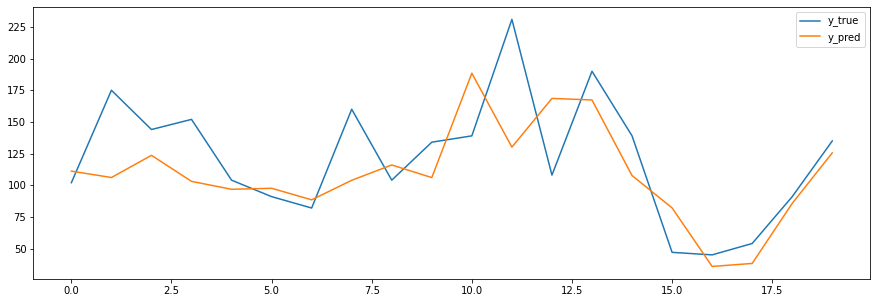

In [ ]:
results3[:20].plot(figsize=(15,5))

### XG Boost

In [ ]:
param = {'max_depth': 2, 'learning_rate': 0.01,'n_estimators':10,'subsample':0.5}
param['nthread'] = 4
param['eval_metric'] = 'mlogloss'

In [ ]:
modelXG = XGBRegressor(n_estimators=50,max_depth=8,
                       max_leaves=2,
                       learning_rate=0.1,
                       booster='dart',
                       base_score=0.1,
                       eval_metric=mean_absolute_error)
modelXG.fit(features_train,target_train,eval_metric=mean_absolute_error)

XGBRegressor(base_score=0.1, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7f4ed397c5e0>,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, max_leaves=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
hasil_mae(modelXG)

MAE train = 9.030149187720912
MAE test = 39.43956428631398


### Machine Learning From Tensoflow.keras

#### Persiapan Data

In [ ]:
df = data_1.copy()
df = df.dropna()
y_col=['num_orders']
print(df.shape)
df.head()

(4411, 12)


,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 05:00:00,6,2018,3,1,3,5,43.0,66.0,71.0,85.0,124.0,77.8
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,66.0,71.0,85.0,54.2
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,43.0,66.0,71.0,39.6
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,43.0,66.0,28.4
2018-03-01 09:00:00,69,2018,3,1,3,9,34.0,15.0,12.0,6.0,43.0,22.0


#### Analisis Data

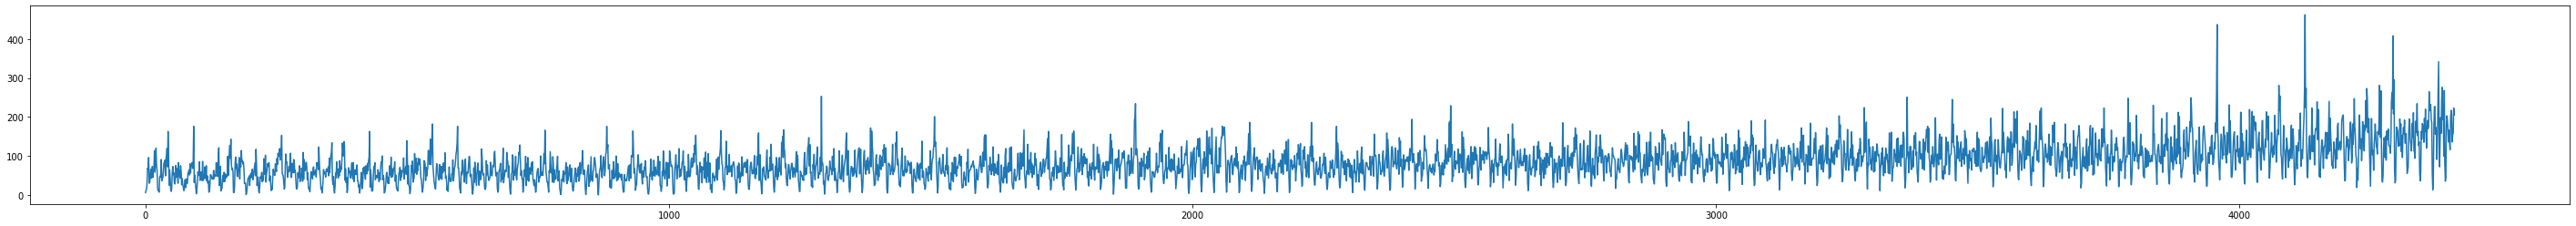

In [ ]:
plt.figure(figsize=(50,4))
plt.plot(range(len(df)),df[y_col]);

In [ ]:
test_size = int(len(df) * 0.1)
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()
print(train.shape, test.shape)

(3970, 12) (441, 12)


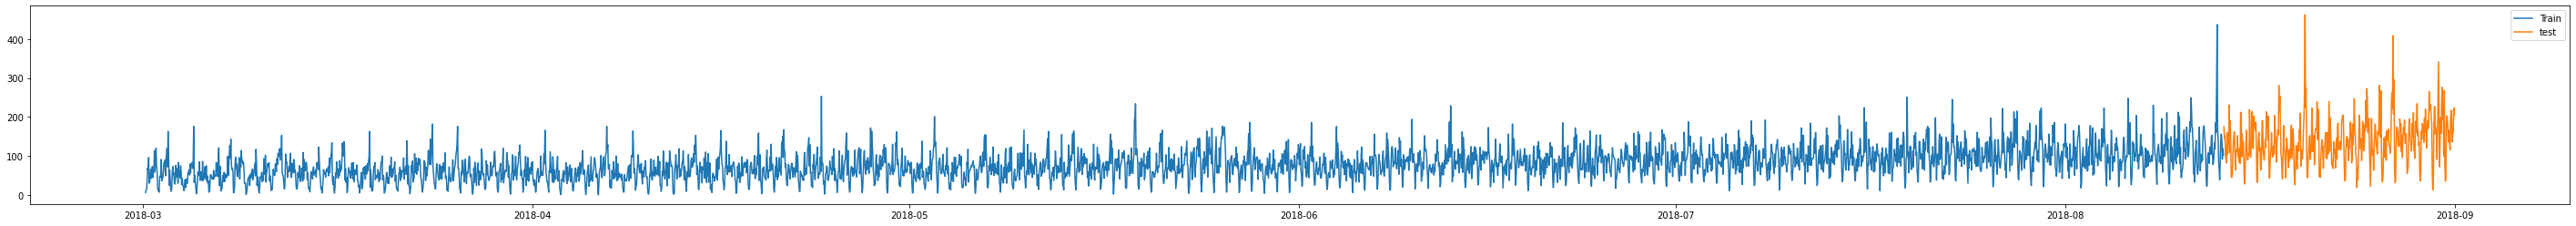

In [ ]:
plt.figure(figsize=(50,4))
plt.plot(train.index,train[y_col],label='Train');
plt.plot(test.index,test[y_col],label='test')
plt.legend();

In [ ]:
X_train = train.drop(y_col,axis=1).copy()
y_train = train[y_col].copy() # the double brakets here are to keep the y in a dataframe format, otherwise it will be pandas Series
print(X_train.shape, y_train.shape)

(3970, 11) (3970, 1)


In [ ]:
Xscaler = MinMaxScaler(feature_range=(0, 1))
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
print(X_train.shape)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape)
scaled_y_train = scaled_y_train.reshape(-1)
print(scaled_y_train.shape)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

(3970, 11)
(3970, 1)
(3970,)


#### Pelatihan

##### LSTM Model

In [ ]:
%%time
n_input = 10 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 24 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

model = Sequential()
model.add(LSTM(150, activation='relu',input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='Nadam', loss='mse')
model.summary()

model.fit(generator,verbose=0,epochs=5,steps_per_epoch=50,shuffle=False)

2023-04-23 17:13:21.041956: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               97200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 97,351
Trainable params: 97,351
Non-trainable params: 0
_________________________________________________________________
CPU times: user 8.71 s, sys: 930 ms, total: 9.65 s
Wall time: 9.88 s


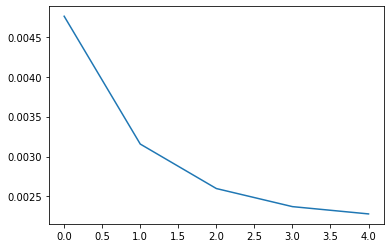

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

<AxesSubplot:>

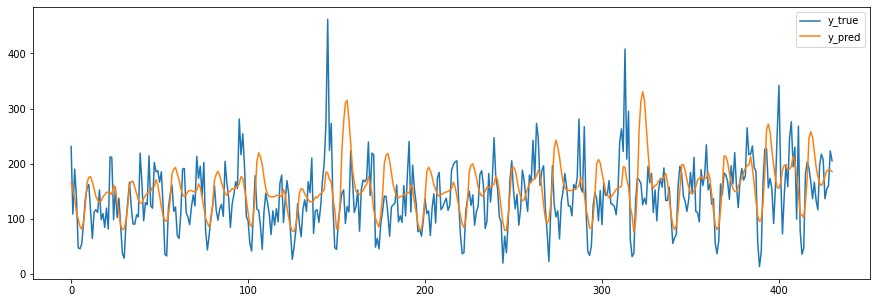

In [ ]:
X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test[y_col].values[n_input:].ravel(),'y_pred':y_pred.ravel()})
results.plot(figsize=(15,5))

In [ ]:
print('MAE test =', mean_absolute_error(test[y_col].values[n_input:],y_pred))

MAE test = 45.291142120715364


##### Linear Model

In [ ]:
modelLM = tf.keras.experimental.LinearModel(activation='elu')

In [ ]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()
modelLM.compile(optimizer=opt, loss=loss_fn)
modelLM.fit(scaled_X_train, scaled_y_train,verbose=0, epochs=20)

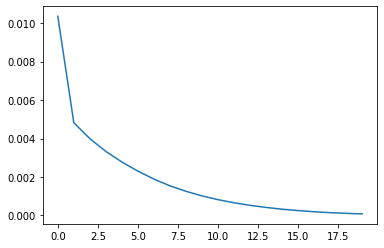

In [ ]:
loss_per_epoch = modelLM.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

###### Train

In [ ]:
y_pred_scaled2 = modelLM.predict(scaled_X_train)
y_pred2 = Yscaler.inverse_transform(y_pred_scaled2)
y_pred2 = pd.Series(y_pred2.ravel()).shift(-1).dropna().ravel()

<AxesSubplot:>

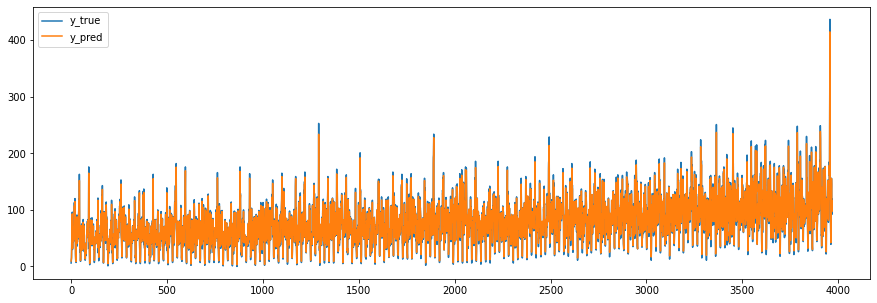

In [ ]:
results = pd.DataFrame({'y_true':train[y_col].values[:-1].ravel(),'y_pred':y_pred2.ravel()})
results.plot(figsize=(15,5))

In [ ]:
print('MAE train =', mean_absolute_error(train[y_col].values[:-1],y_pred2.ravel()))

MAE train = 2.6767156896617617


###### Test

<AxesSubplot:>

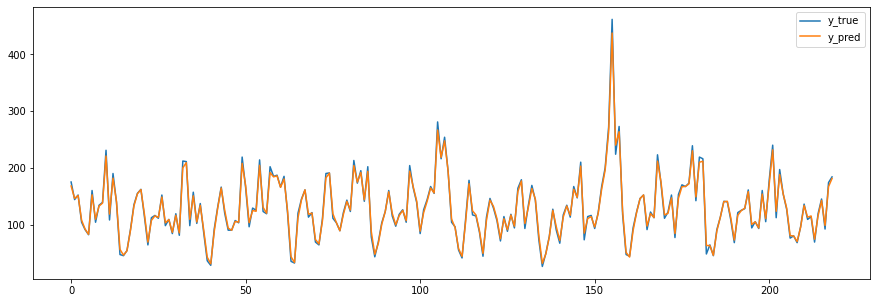

In [ ]:
Xscaler = MinMaxScaler(feature_range=(0, 1))
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
scaled_X_test = Xscaler.transform(X_test)

test_size = int(len(scaled_X_test)/2)
y_pred_scaled = modelLM.predict(scaled_X_test[:test_size])
y_pred = Yscaler.inverse_transform(y_pred_scaled)
y_pred = pd.Series(y_pred.ravel()).shift(-1).dropna().ravel()
results2 = pd.DataFrame({'y_true':test[y_col].values[:test_size-1].ravel(),'y_pred':y_pred.ravel()})
results2.plot(figsize=(15,5))

In [ ]:
print('MAE test =', mean_absolute_error(test[y_col].values[:test_size-1].ravel(),y_pred.ravel()))

MAE test = 4.07085034618639


<AxesSubplot:>

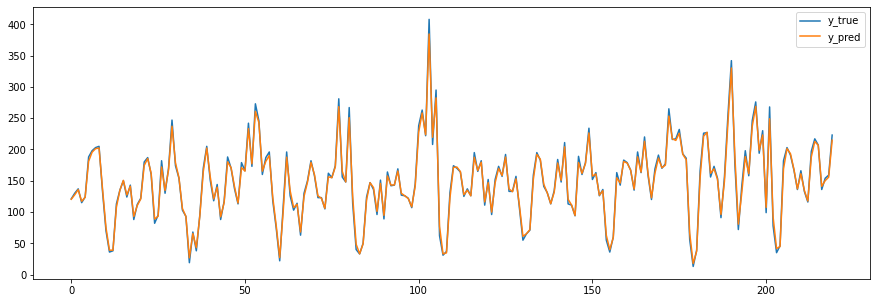

In [ ]:
y_pred_scaled = modelLM.predict(scaled_X_test[test_size:])
y_pred = Yscaler.inverse_transform(y_pred_scaled)
y_pred = pd.Series(y_pred.ravel()).shift(-1).dropna().ravel()
results2 = pd.DataFrame({'y_true':test[y_col].values[test_size:-1].ravel(),'y_pred':y_pred.ravel()})
results2.plot(figsize=(15,5))

In [ ]:
print('MAE test =', mean_absolute_error(test[y_col].values[test_size:-1].ravel(),y_pred.ravel()))

MAE test = 4.437259977514094


In [ ]:
results2

,y_true,y_pred
0,121,120.398003
1,130,127.541939
2,137,135.734009
3,115,117.190514
4,124,123.527153
...,...,...
215,207,206.567917
216,136,141.042953
217,154,150.196548
218,159,155.727386


## Test

In [ ]:
test_1,test_2 = train_test_split(test, shuffle=False, test_size=0.5)
test_3 = test.copy()
y_col=['num_orders']
print(test_1.shape,test_2.shape,train.shape,test_3.shape)

In [ ]:
plt.figure(figsize=(50,4))
plt.plot(train.index,train[y_col],label='Train');
plt.plot(test_1.index,test_1[y_col],label='test_1');
plt.plot(test_2.index,test_2[y_col],label='test_2');
plt.legend();

In [ ]:
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
print(X_train.shape)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape)
scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_train.shape)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

In [ ]:
modelLM1 = tf.keras.experimental.LinearModel(activation='selu')

In [ ]:
opt = tf.keras.optimizers.Adamax()
loss_fn = tf.keras.losses.MeanSquaredError()
modelLM1.compile(optimizer=opt, loss=loss_fn)
modelLM1.fit(X_train, y_train,verbose=0, epochs=20)

In [ ]:
loss_per_epoch = modelLM1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [ ]:
y_pred_scaled2 = modelLM1.predict(X_train)
y_pred2 = pd.Series(y_pred_scaled2.ravel()).shift(-1).dropna().ravel()

In [ ]:
results = pd.DataFrame({'y_true':train[y_col].values[:-1].ravel(),'y_pred':y_pred2.ravel()})
results.plot(figsize=(15,5))

In [ ]:
print('MAE train =', mean_absolute_error(train[y_col].values[:-1],y_pred2.ravel()))

In [ ]:
X_test_1 = test_1.drop(y_col,axis=1).copy()
X_test_2 = test_2.drop(y_col,axis=1).copy()
X_test_3 = test_3.drop(y_col,axis=1).copy()

In [ ]:
y_pred_scaled = modelLM1.predict(X_test_1)
y_pred_3 = pd.Series(y_pred_scaled.ravel()).shift(-1).dropna().ravel()

In [ ]:
results = pd.DataFrame({'y_true':test_1[y_col].values[:-1].ravel(),'y_pred':y_pred_3.ravel()})
results.plot(figsize=(15,5))

In [ ]:
print('MAE test_1 =', mean_absolute_error(test_1[y_col].values[:-1],y_pred_3.ravel()))

In [ ]:
y_pred_scaled_1 = modelLM1.predict(X_test_2)
y_pred_4 = pd.Series(y_pred_scaled_1.ravel()).shift(-1).dropna().ravel()

In [ ]:
results = pd.DataFrame({'y_true':test_2[y_col].values[:-1].ravel(),'y_pred':y_pred_4.ravel()})
results.plot(figsize=(15,5))

In [ ]:
print('MAE test_1 =', mean_absolute_error(test_2[y_col].values[:-1],y_pred_4.ravel()))

In [ ]:
y_pred_scaled_2 = modelLM1.predict(X_test_3)
y_pred_5 = pd.Series(y_pred_scaled_2.ravel()).shift(-1).dropna().ravel()

In [ ]:
results = pd.DataFrame({'y_true':test_3[y_col].values[:-1].ravel(),'y_pred':y_pred_5.ravel()})
results.plot(figsize=(15,5))

In [ ]:
print('MAE test_1 =', mean_absolute_error(test_3[y_col].values[:-1],y_pred_5.ravel()))

## Kesimpulan

Dengan dilakukan nya Pelatihan dengan beberapa sumber Machine Learning yang berbeda di dapat hasil seperti berikut.
1. LinearRegression MAE train = 23.41691199116744, MAE test = 40.00196804324518
    **MAE Test sudah di bawah 48, tetapi overfitting**
2. Decisiion Tree MAE train = 14.766934990185364 , MAE test = 41.573809543106414
    **MAE Test tidak lebih bagus dibanding kan Linear Regression, dan malah lebih overfitting terhadap MAE train.**
3. Random Forest MAE train = 16.213055378209727, MAE test = 41.40418879750041
    **MAE Test tidak lebih bagus dibanding kan Linear Regression, dan malah lebih overfitting terhadap MAE train.**
4. LightGBM MAE train = 12.040308914843862, MAE test = 33.59639967512981
    **MAE Test lebih bagus dibanding LinearRegression, tetapi masih overfitting terhadap MAE Train**
5. Cat Boost MAE train = 10.655358377980532, MAE test = 37.13768947357293
    **MAE Test tidak lebih bagus dibanding kan LightGBM, dan malah lebih overfitting terhadap MAE train.**
6. XG Boost MAE train = 9.030149187720912, MAE test = 39.43956428631398
    **MAE Test tidak lebih bagus dibanding kan LightGBM, dan malah lebih overfitting terhadap MAE train.**
7. Machine Learning From Tensorflow.keras
    1. LSTM Model MAE test = 41.056661530603115, MAE masih tinggi dengan waktu eksekusi cukup lama
    2. Linear Model MAE train = 2.62874111104414, MAE test = 4.286456662958319,
        **Model ini sangat bagus dimana Hasil dari MAE train dan MAE test tidak overfitting, dan juga waktu eksekusi yang cepat. dan hasil dari MAE test yang sangat kecil dibanding dengan model Machine Learning lain nya.**